To build an effective model, I investigated which data is useful, and which is not. I will share the result.


# About Each File
* train.csv: main data for training
* oil.csv: the price of oil data by date
* holidays_events.csv: holiday & event data by date
* stores.csv: the stores data by store
* transactions.csv: transaction data

# Data Import

In [1]:
# library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:

train_df = pd.read_csv(train_path)
store_df = pd.read_csv(stores_path)
oil_df = pd.read_csv(oil_path)
holidays_events_df = pd.read_csv(holidays_events_path)

# Oil Price Correlation
Check the correlation between the oil price and the sales using two horizontal bar.

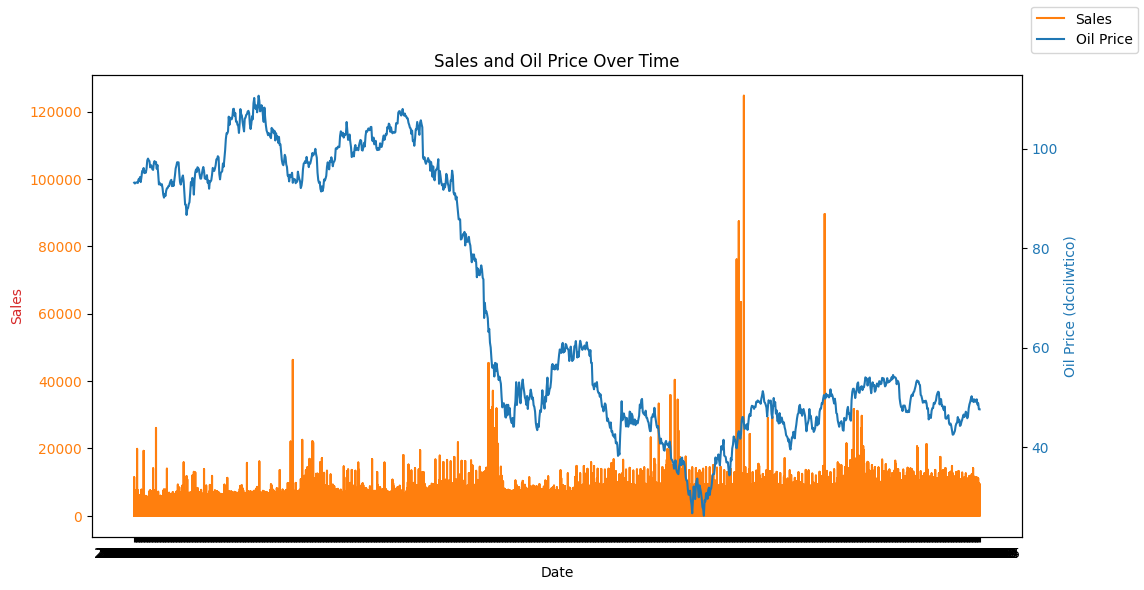

In [4]:
merged_df = pd.merge(train_df, oil_df, on='date', how='left')

oil_sales = merged_df.groupby('date')['sales'].sum().reset_index()

# drop missing data
merged_df.dropna(subset=['sales', 'dcoilwtico'], inplace=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

# plot for sales
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color='tab:red')
sales_line, = ax1.plot(merged_df['date'], merged_df['sales'], color='tab:orange', label='Sales')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# plot for oil price
ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price (dcoilwtico)', color='tab:blue')
oil_line, = ax2.plot(merged_df['date'], merged_df['dcoilwtico'], color='tab:blue', label='Oil Price')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Sales and Oil Price Over Time')
fig.legend(handles=[sales_line, oil_line], loc='upper right')
plt.show()

It seems that the oil price doesn't significantly influence the sales.

# Promotion
Check the correlation between the promotion and the sales. The promotion data is in 'onpromotion' column of train.csv.

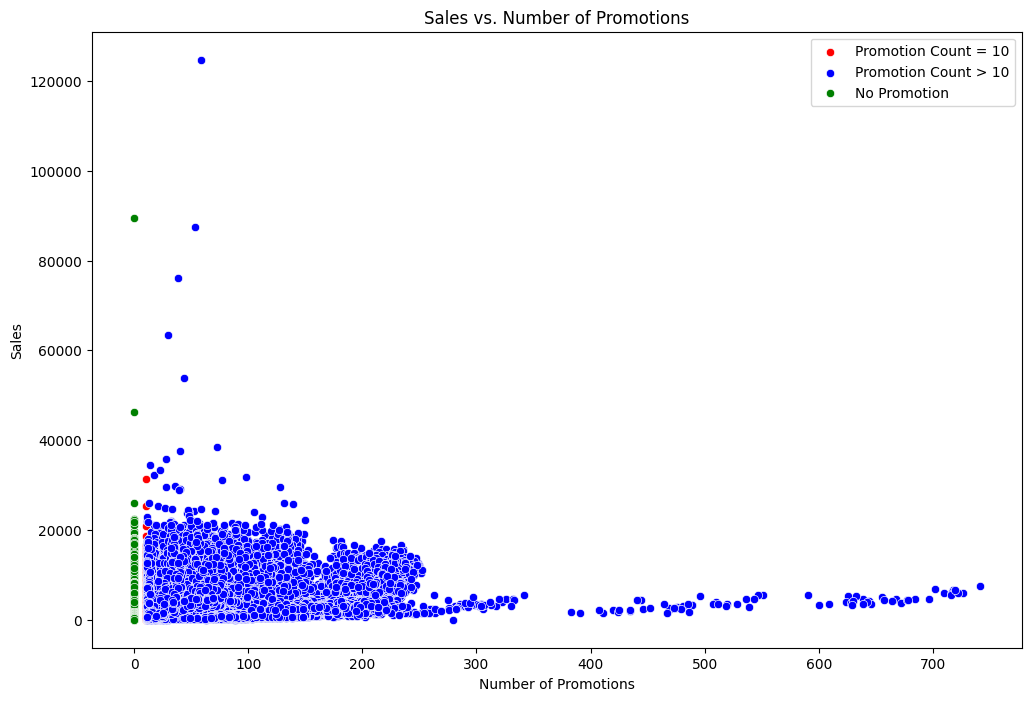

In [5]:
plt.figure(figsize=(12, 8))
# The number of 'onpromotion' is bigger than 10
sns.scatterplot(x='onpromotion', y='sales', data=train_df[train_df['onpromotion'] == 10], color='red', label='Promotion Count = 10')
# The number of 'onpromotion' is less than 10
sns.scatterplot(x='onpromotion', y='sales', data=train_df[train_df['onpromotion'] > 10], color='blue', label='Promotion Count > 10')
# The number of 'onpromotion' is 0
sns.scatterplot(x='onpromotion', y='sales', data=train_df[train_df['onpromotion'] == 0], color='green', label='No Promotion')
plt.title('Sales vs. Number of Promotions')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
plt.legend()
plt.show()

It seems that the promotion doesn't significantly influence the sales.

# Holiday
Check the correlation between the holidays and the sales using data from holidays_events.csv.
While some holidays are transferred and could be redefined for an exact analysis, let's ignore them for a general overview.

In [6]:
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
train_df['date'] = pd.to_datetime(train_df['date'])

holiday_types = ['Holiday', 'Additional', 'Bridge', 'Work Day', 'Transfer', 'Event']
for holiday_type in holiday_types:
    holidays_events_df[holiday_type] = (holidays_events_df['type'] == holiday_type).astype(int)

train_df = pd.merge(train_df, holidays_events_df[['date'] + holiday_types], on='date', how='left')
train_df[holiday_types] = train_df[holiday_types].fillna(0).astype(int)

train_df.head()


,id,date,store_nbr,family,sales,onpromotion,Holiday,Additional,Bridge,Work Day,Transfer,Event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,0,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,1,0,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,1,0,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,0,0,0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,1,0,0,0,0,0


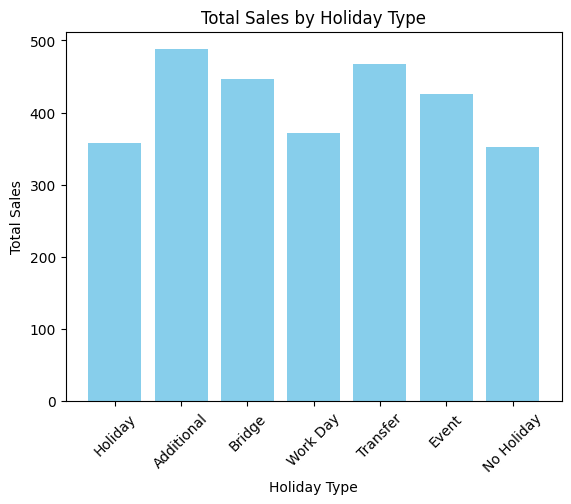

In [7]:
holiday_sales_means = {}

for holiday_type in holiday_types:
    filtered_rows = train_df[train_df[holiday_type] == 1.0]
    holiday_sales_means[holiday_type] = filtered_rows['sales'].mean()

no_holiday_data = train_df[(train_df[holiday_types].sum(axis=1) == 0)]
holiday_sales_means['No Holiday'] = no_holiday_data['sales'].mean()


fig, ax = plt.subplots()
ax.bar(holiday_sales_means.keys(), holiday_sales_means.values(), color='skyblue')
ax.set_title('Total Sales by Holiday Type')
ax.set_xlabel('Holiday Type')
ax.set_ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()



It appears that days marked as Additional, Bridge, Transfer, or Event might influence sales.

I also examined the impact of the 'locale' in the holidays_events.csv file, which indicates the scope of the holiday. The results are as follows. This attribute appears to have some impact on sales.

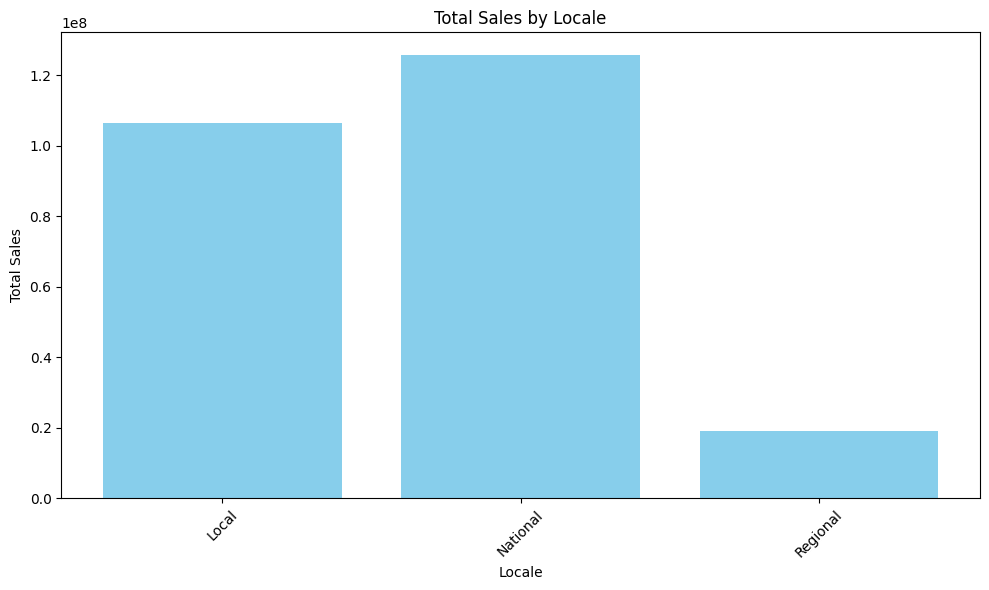

In [8]:
# holiday local
merged_df = pd.merge(train_df, holidays_events_df, on='date', how='left')
locale_sales = merged_df.groupby('locale')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(locale_sales['locale'], locale_sales['sales'], color='skyblue')
plt.title('Total Sales by Locale')
plt.xlabel('Locale')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Family
Check "family" in train.csv, which appears the product categlry. First, use the one-hot encoding to transform the categorical data and then check the total sales for each category.

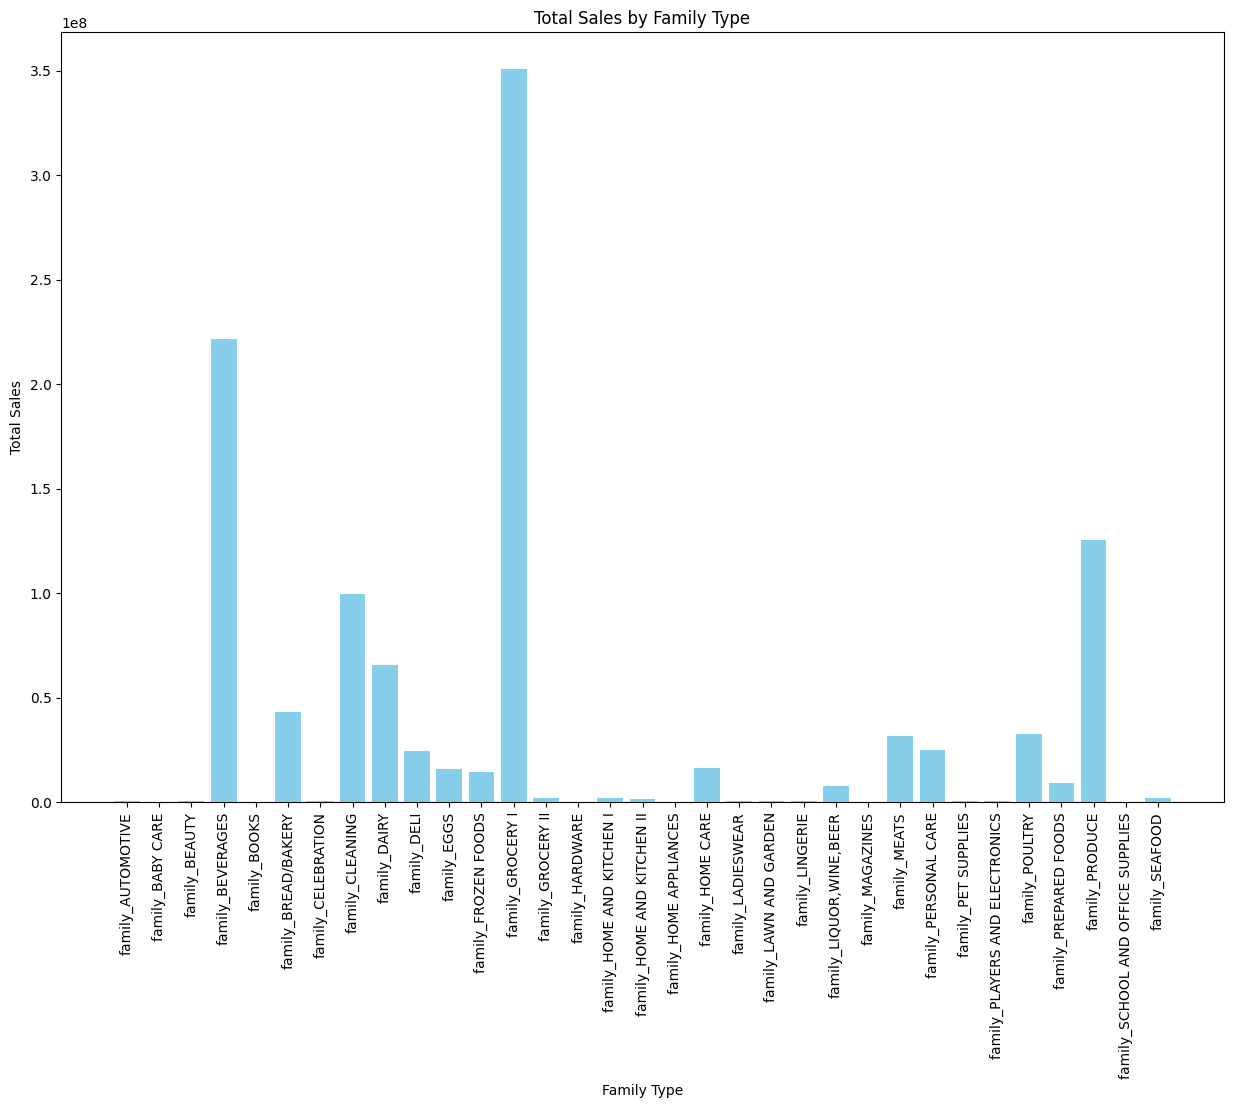

In [9]:
train_df = pd.get_dummies(train_df, columns=['family'])

family_types = [col for col in train_df.columns if col.startswith('family_')]
family_sales_sum = {}

for family_type in family_types:
    filtered_rows = train_df[train_df[family_type] == 1.0]
    family_sales_sum[family_type] = filtered_rows['sales'].sum()

fig, ax = plt.subplots(figsize=(15, 10)) 
ax.bar(family_sales_sum.keys(), family_sales_sum.values(), color='skyblue')
ax.set_title('Total Sales by Family Type')
ax.set_xlabel('Family Type')
ax.set_ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()


It appears that the family significantly influences the sals.

# Date
The day of the week and the month also might effect the sales. Let's check them, staring with the effect of the day.

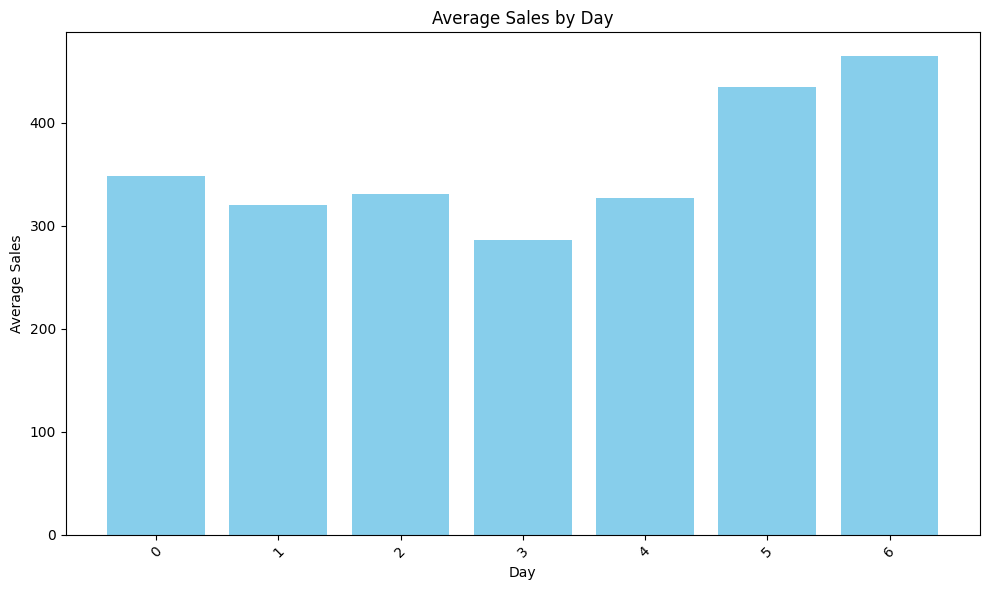

In [10]:
train_df['date'] = pd.to_datetime(train_df['date'])

# Add day of the week as new columns
# 0 is Monday
train_df['day_of_week'] = train_df['date'].dt.dayofweek

train_df[['id', 'date', 'day_of_week']]

day_avg_sales = train_df.groupby('day_of_week')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(day_avg_sales['day_of_week'], day_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Day')
plt.xlabel('Day')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The sales is higher during Weekend which we can easily expect.

Next, let's check the impact of the month.

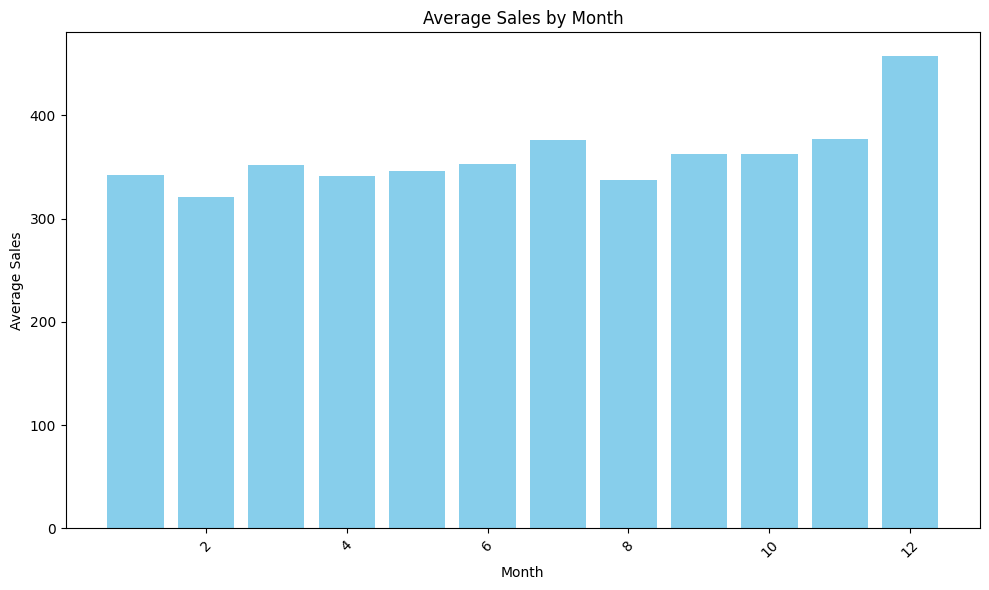

In [11]:
# Add month as new columns
train_df['month'] = train_df['date'].dt.month
month_avg_sales = train_df.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(month_avg_sales['month'], month_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

December's sales is higher than others, which we also can expect.


I also examined the day of the month as follows.

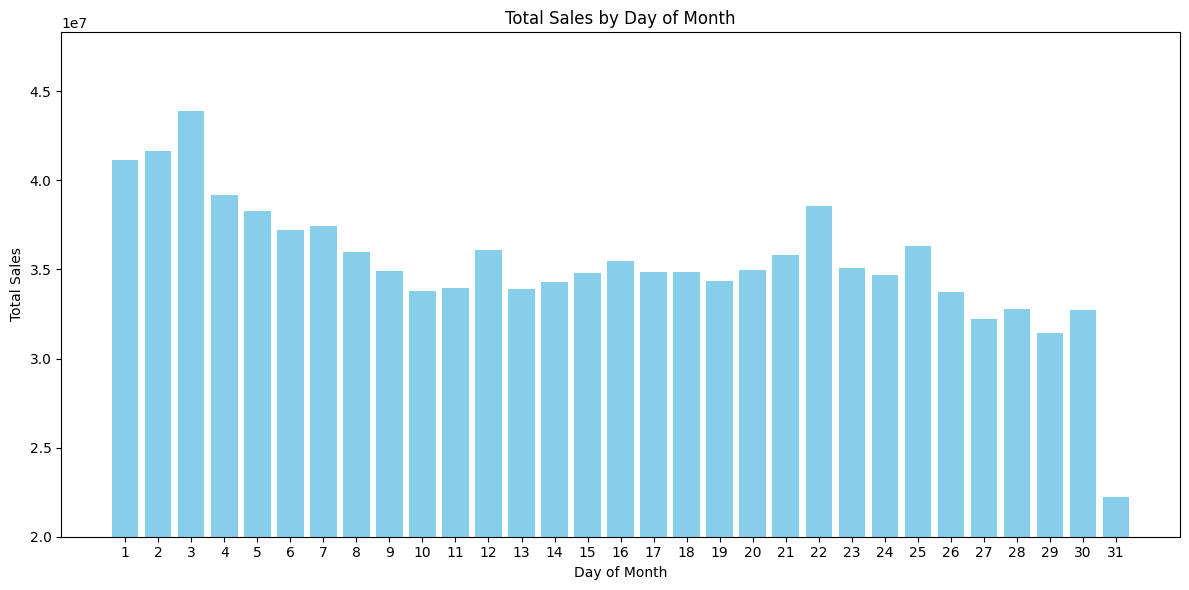

In [12]:
# Add day_of_month as new columns
train_df['day_of_month'] = train_df['date'].dt.day
day_of_month_sales_sum = train_df.groupby('day_of_month')['sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(day_of_month_sales_sum['day_of_month'], day_of_month_sales_sum['sales'], color='skyblue')
plt.title('Total Sales by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 32)) 
plt.ylim(20000000, day_of_month_sales_sum['sales'].max() * 1.1) 
plt.tight_layout()
plt.show()


# Store
Let's check the impact of store. 

It is expected that the store location has a strong influence on sales figures.It has strong impact on the sales.


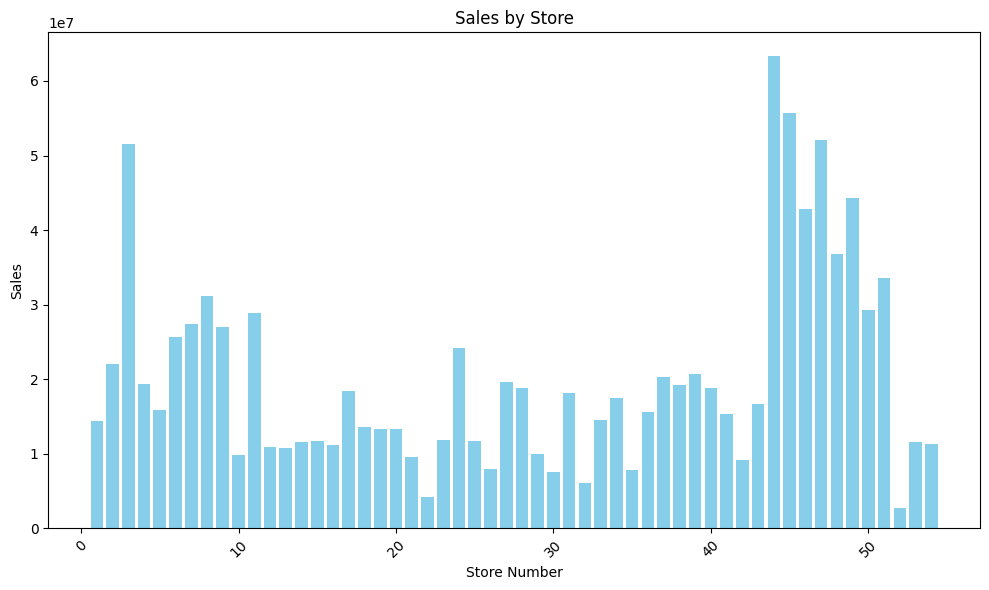

In [13]:
store_sales_sum = train_df.groupby('store_nbr')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(store_sales_sum['store_nbr'], store_sales_sum['sales'], color='skyblue')
plt.title('Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


BTW, the stores details also have some impact on sales.

The stores details are included in stores.csv. Finally let's check those influence.

# Store Type

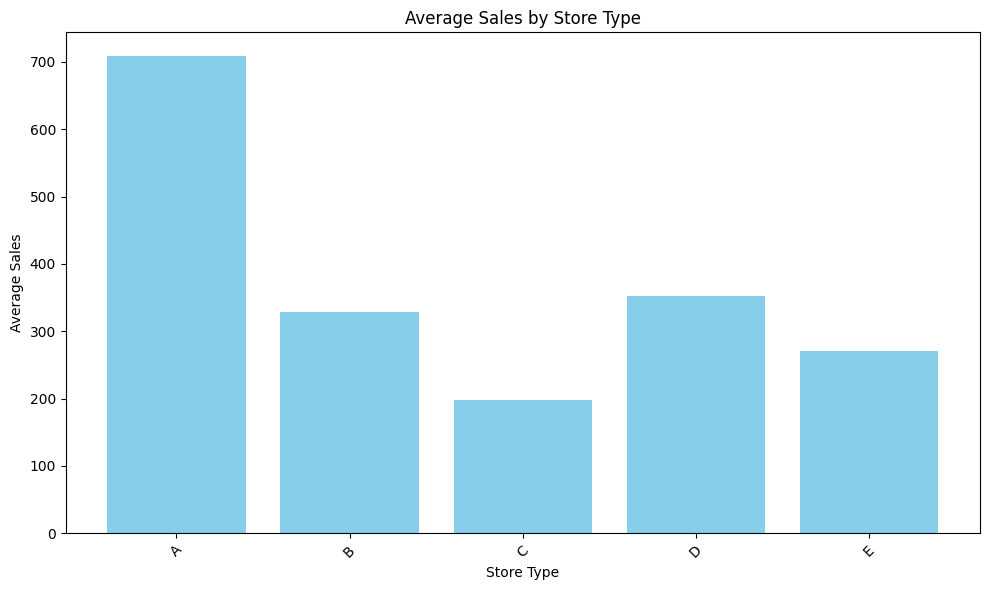

In [14]:
merged_df = pd.merge(train_df, store_df, on='store_nbr', how='left')
type_avg_sales = merged_df.groupby('type')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(type_avg_sales['type'], type_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Store Cluster

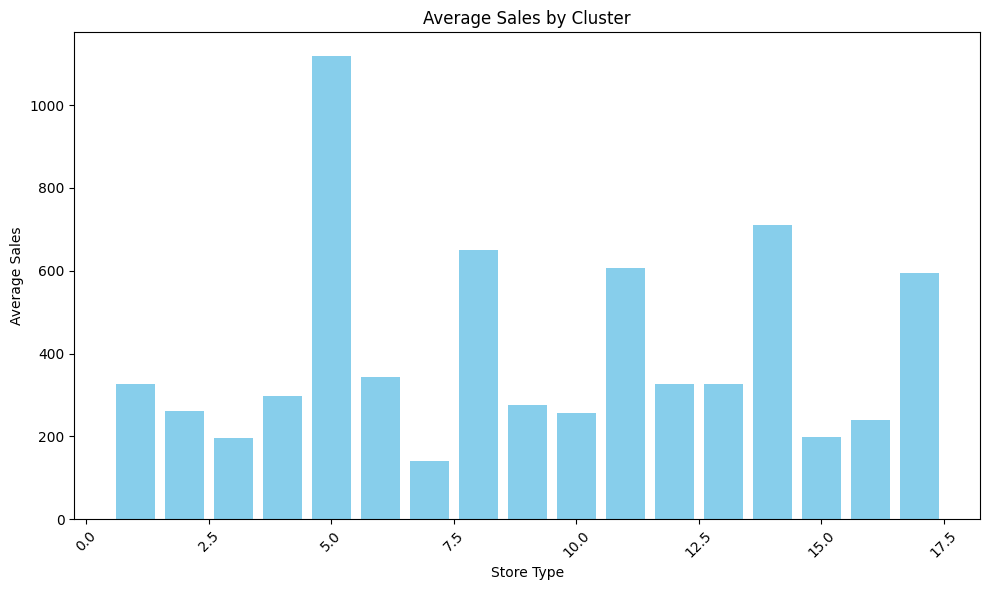

In [15]:
type_avg_sales = merged_df.groupby('cluster')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(type_avg_sales['cluster'], type_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by Cluster')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Store City

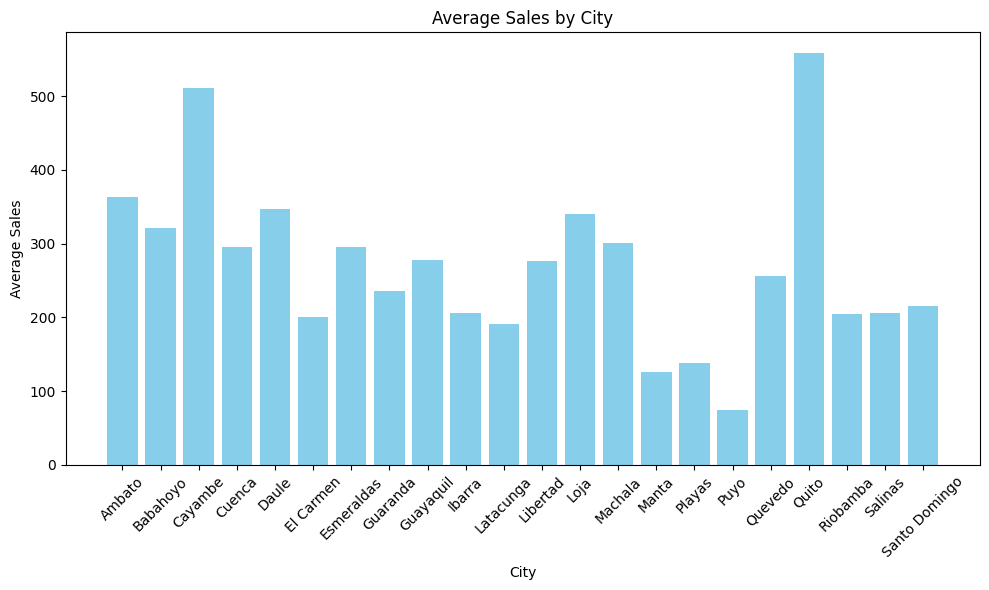

In [16]:
city_avg_sales = merged_df.groupby('city')['sales'].mean().reset_index()


plt.figure(figsize=(10, 6))
plt.bar(city_avg_sales['city'], city_avg_sales['sales'], color='skyblue')
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
